In [88]:
# GNN and Tabular Transformer (Address-level)
# Single-file notebook-style script using cell separators (for Jupyter/VSCode: Run cells)
# This version is tailored for the provided file: /mnt/data/ethereum_raw.csv
# It assumes the file is already address-level with columns: 'Address' (ID) and 'FLAG' (label).
# The notebook will: load data, preprocess, build a KNN similarity graph for GNN, train a node-classifier GNN and a Tabular Transformer, evaluate and save artifacts.


In [89]:
# 1) Setup & imports
import os
import random
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, precision_recall_fscore_support, accuracy_score
from sklearn.neighbors import NearestNeighbors

# For GNN
try:
    import torch_geometric
    from torch_geometric.data import Data
    from torch_geometric.nn import SAGEConv
except Exception as e:
    print("torch_geometric not installed or import failed:", e)

# For baseline
try:
    import lightgbm as lgb
except Exception:
    lgb = None

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DATA_PATH = 'E:/Projects/CBK_Assignment/Greenland_Registry/ethereum_raw.csv'
ARTIFACTS_DIR = './artifacts'
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

os.makedirs(ARTIFACTS_DIR, exist_ok=True)


In [90]:
# 2) Load CSV & quick EDA
print('Loading', DATA_PATH)
df = pd.read_csv(DATA_PATH)
print('Rows, cols:', df.shape)
print(df.columns.tolist())
print(df.head(3))


Loading E:/Projects/CBK_Assignment/Greenland_Registry/ethereum_raw.csv
Rows, cols: (9841, 51)
['Unnamed: 0', 'Index', 'Address', 'FLAG', 'Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Number of Created Contracts', 'Unique Received From Addresses', 'Unique Sent To Addresses', 'min value received', 'max value received ', 'avg val received', 'min val sent', 'max val sent', 'avg val sent', 'min value sent to contract', 'max val sent to contract', 'avg value sent to contract', 'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received', 'total ether sent contracts', 'total ether balance', ' Total ERC20 tnxs', ' ERC20 total Ether received', ' ERC20 total ether sent', ' ERC20 total Ether sent contract', ' ERC20 uniq sent addr', ' ERC20 uniq rec addr', ' ERC20 uniq sent addr.1', ' ERC20 uniq rec contract addr', ' ERC20 avg time between sent tnx', ' ERC20 avg time between 

In [91]:
# remove leaking index-like columns
if 'Unnamed: 0' or 'Index' in df.columns:
    df = df.drop(columns=['Unnamed: 0', 'Index'], errors='ignore')
df.head(5)

,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,118,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,14,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,2,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,13,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,19,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [92]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pickle, numpy as np, os

# Assumptions: df is already loaded, contains columns 'Address' and 'FLAG'
# If your notebook had explicit lists for numeric/categorical columns, reuse them.
# Otherwise auto-detect:
feature_cols = [c for c in df.columns if c not in ('Address', 'FLAG', 'flag', 'Label', 'label')]
addresses = df['Address'].values
y = df['FLAG'].values

# crude split of categorical vs numeric (you can override lists if you had custom lists)
categorical_cols = [c for c in feature_cols if df[c].dtype == 'object' or df[c].nunique() < 50]
numeric_cols = [c for c in feature_cols if c not in categorical_cols]

# INDEX-BASED SPLIT (stratified)
idx = np.arange(len(df))
train_idx, test_idx = train_test_split(idx, test_size=0.20, random_state=SEED, stratify=y)
train_idx, val_idx  = train_test_split(train_idx, test_size=0.15, random_state=SEED, stratify=y[train_idx])
print(f"Split sizes: train={len(train_idx)}, val={len(val_idx)}, test={len(test_idx)}")

# Prepare raw column-wise arrays for convenience
X_raw_num = df[numeric_cols].copy()
X_raw_cat = df[categorical_cols].copy()

# --- Fit transformers ON TRAIN ONLY ---
# 1) LabelEncoders for categorical columns
cat_encoders = {}
X_cat = np.empty((len(df), len(categorical_cols)), dtype=np.int32)
for i, col in enumerate(categorical_cols):
    le = LabelEncoder()
    # fillna with a token so unseen missing doesn't break
    train_vals = X_raw_cat.iloc[train_idx][col].fillna("<<NA>>").astype(str)
    le.fit(train_vals)
    # transform all rows (val/test will map unseen -> error with LabelEncoder),
    # so use mapping with get() to map unseen to a new index (len(le.classes_))
    mapping = {v: idx_ for idx_, v in enumerate(le.classes_)}
    unk_index = len(mapping)
    # apply mapping safely:
    X_cat[:, i] = X_raw_cat[col].fillna("<<NA>>").astype(str).map(lambda x: mapping.get(x, unk_index)).values
    cat_encoders[col] = {"label_encoder": le, "mapping": mapping, "unk_index": unk_index}

# 2) StandardScaler for numeric columns (fit on train numeric only)
scaler = StandardScaler()
scaler.fit(X_raw_num.iloc[train_idx].fillna(0).values)   # choose an imputation (0) or better impute on train

# transform numeric for all sets
X_num_scaled = scaler.transform(X_raw_num.fillna(0).values)

# --- Build final X arrays (concatenate numeric + encoded categorical) ---
X_all = np.hstack([X_num_scaled, X_cat.astype(float)])   # ensure float for models

# split into train/val/test arrays
X_train = X_all[train_idx]
X_val   = X_all[val_idx]
X_test  = X_all[test_idx]

y_train = y[train_idx]
y_val   = y[val_idx]
y_test  = y[test_idx]

addresses_train = addresses[train_idx]
addresses_val   = addresses[val_idx]
addresses_test  = addresses[test_idx]

# drop = ['suspect_col1','suspect_col2']
# X_train = X_train.drop(columns=drop).values  # adapt to your code

print("Feature count:", X_all.shape[1])

# Save artifacts (scalers/encoders + splits) so downstream cells use train-fitted objects
os.makedirs(ARTIFACTS_DIR, exist_ok=True)
with open(os.path.join(ARTIFACTS_DIR, "preproc_train_encoders.pkl"), "wb") as f:
    pickle.dump({"categorical_cols": categorical_cols,
                 "numeric_cols": numeric_cols,
                 "cat_encoders": cat_encoders,
                 "scaler": scaler,
                 "feature_cols": feature_cols}, f)

# Save numpy splits used by later cells
np.save(os.path.join(ARTIFACTS_DIR, "X_train.npy"), X_train)
np.save(os.path.join(ARTIFACTS_DIR, "X_val.npy"), X_val)
np.save(os.path.join(ARTIFACTS_DIR, "X_test.npy"), X_test)
np.save(os.path.join(ARTIFACTS_DIR, "y_train.npy"), y_train)
np.save(os.path.join(ARTIFACTS_DIR, "y_val.npy"), y_val)
np.save(os.path.join(ARTIFACTS_DIR, "y_test.npy"), y_test)
np.save(os.path.join(ARTIFACTS_DIR, "addresses_train.npy"), addresses_train)
np.save(os.path.join(ARTIFACTS_DIR, "addresses_val.npy"), addresses_val)
np.save(os.path.join(ARTIFACTS_DIR, "addresses_test.npy"), addresses_test)

print("Saved train-only preproc artifacts to", ARTIFACTS_DIR)
# ----- END REPLACEMENT BLOCK -----


Split sizes: train=6691, val=1181, test=1969
Feature count: 47
Saved train-only preproc artifacts to ./artifacts


In [93]:
# ---- LightGBM hyperparameter tuning (RandomizedSearchCV version - faster) ----
import os, numpy as np, joblib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from lightgbm import LGBMClassifier
from scipy.stats import randint, uniform

ARTIFACTS_DIR = './artifacts'

# load pre-saved splits (do NOT re-split)
X_train = np.load(os.path.join(ARTIFACTS_DIR, "X_train.npy"))
X_val   = np.load(os.path.join(ARTIFACTS_DIR, "X_val.npy"))
X_test  = np.load(os.path.join(ARTIFACTS_DIR, "X_test.npy"))
y_train = np.load(os.path.join(ARTIFACTS_DIR, "y_train.npy"))
y_val   = np.load(os.path.join(ARTIFACTS_DIR, "y_val.npy"))
y_test  = np.load(os.path.join(ARTIFACTS_DIR, "y_test.npy"))

# param search space (Randomized)
param_distributions = {
    'num_leaves': randint(31, 256),
    'learning_rate': uniform(0.01, 0.09),
    'n_estimators': randint(100, 800),
    'max_depth': randint(4, 20),
    'min_child_samples': randint(10, 150),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

# build base estimator (note: variable name won't shadow module)
base_est = LGBMClassifier(objective='binary', random_state=42, n_jobs=-1, class_weight='balanced')

# RandomizedSearchCV (refit=True by default -> best estimator available as .best_estimator_)
search = RandomizedSearchCV(
    estimator=base_est,
    param_distributions=param_distributions,
    n_iter=25,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=2,
    refit=True
)

print("Starting RandomizedSearchCV for LightGBM (using X_train)...")
search.fit(X_train, y_train)

print("\nBest params:", search.best_params_)
print("Best CV ROC-AUC:", search.best_score_)

# best estimator (already refit on X_train)
best_lgb = search.best_estimator_

# Evaluate on val and test sets
def eval_and_print(name, model, X_, y_):
    probs = model.predict_proba(X_)[:, 1]
    preds = model.predict(X_)
    print(f"\n== {name.upper()} Metrics ==")
    print("ROC-AUC:", roc_auc_score(y_, probs))
    print("PR-AUC:", average_precision_score(y_, probs))
    print("Classification report:\n", classification_report(y_, preds))

eval_and_print('val', best_lgb, X_val, y_val)
eval_and_print('test', best_lgb, X_test, y_test)

# Save tuned model and predictions
joblib.dump(best_lgb, os.path.join(ARTIFACTS_DIR, "lgb_best.pkl"))
np.save(os.path.join(ARTIFACTS_DIR, "lgb_test_probs.npy"), best_lgb.predict_proba(X_test)[:,1])
np.save(os.path.join(ARTIFACTS_DIR, "lgb_test_preds.npy"), best_lgb.predict(X_test))
np.save(os.path.join(ARTIFACTS_DIR, "lgb_test_true.npy"), y_test)
print("\nSaved tuned LightGBM to", os.path.join(ARTIFACTS_DIR, "lgb_best.pkl"))
# ---- end replacement block ----


Starting RandomizedSearchCV for LightGBM (using X_train)...
Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best params: {'colsample_bytree': np.float64(0.7123738038749523), 'learning_rate': np.float64(0.05884264748424236), 'max_depth': 12, 'min_child_samples': 24, 'n_estimators': 164, 'num_leaves': 119, 'subsample': np.float64(0.9947547746402069)}
Best CV ROC-AUC: 0.9993918895819105

== VAL Metrics ==
ROC-AUC: 0.9997251374312843
PR-AUC: 0.999105283687304
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       920
           1       1.00      0.97      0.98       261

    accuracy                           0.99      1181
   macro avg       0.99      0.99      0.99      1181
weighted avg       0.99      0.99      0.99      1181


== TEST Metrics ==
ROC-AUC: 0.999527220716111
PR-AUC: 0.998562263791687
Classification report:
               precision    recall  f1-score   support

           0       0.9

e:\Projects\CBK_Assignment\Greenland_Registry\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
e:\Projects\CBK_Assignment\Greenland_Registry\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
e:\Projects\CBK_Assignment\Greenland_Registry\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
e:\Projects\CBK_Assignment\Greenland_Registry\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
e:\Projects\CBK_Assignment\Greenland_Registry\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X d

In [94]:
# 4) Build KNN graph from feature similarity (for GNN node classification)
# We'll build an undirected kNN graph where each node connects to its k nearest neighbours
K = 10
print('Building kNN graph with k=', K)
# ---- INSERT THIS (reconstruct X/y/addresses and split indices) ----
import numpy as np, os
ARTIFACTS_DIR = './artifacts'

# if X already exists in memory do nothing; otherwise load saved splits and concat
# ---- PATCH: load splits (use allow_pickle=True for object/string arrays) ----
if 'X' not in globals():
    X_train = np.load(os.path.join(ARTIFACTS_DIR, "X_train.npy"))
    X_val   = np.load(os.path.join(ARTIFACTS_DIR, "X_val.npy"))
    X_test  = np.load(os.path.join(ARTIFACTS_DIR, "X_test.npy"))
    y_train = np.load(os.path.join(ARTIFACTS_DIR, "y_train.npy"))
    y_val   = np.load(os.path.join(ARTIFACTS_DIR, "y_val.npy"))
    y_test  = np.load(os.path.join(ARTIFACTS_DIR, "y_test.npy"))
    # addresses saved as object/string arrays -> allow pickle to load them
    a_tr = np.load(os.path.join(ARTIFACTS_DIR, "addresses_train.npy"), allow_pickle=True)
    a_va = np.load(os.path.join(ARTIFACTS_DIR, "addresses_val.npy"), allow_pickle=True)
    a_te = np.load(os.path.join(ARTIFACTS_DIR, "addresses_test.npy"), allow_pickle=True)
# ---- end patch ----


    # Recreate a single X/y/addresses variable by concatenating train -> val -> test.
    # This gives a coherent node indexing for the KNN graph (nodes 0..n_train-1 = train, etc.).
    X = np.vstack([X_train, X_val, X_test])
    y = np.concatenate([y_train, y_val, y_test])
    addresses = np.concatenate([a_tr, a_va, a_te])

    # create split indices (downstream code that expects train_idx/val_idx/test_idx will work)
    n_train = X_train.shape[0]
    n_val   = X_val.shape[0]
    n_test  = X_test.shape[0]
    train_idx = np.arange(0, n_train)
    val_idx   = np.arange(n_train, n_train + n_val)
    test_idx  = np.arange(n_train + n_val, n_train + n_val + n_test)

    print("Reconstructed X shape:", X.shape, "  splits:", n_train, n_val, n_test)
# ---- end insertion ----

knn = NearestNeighbors(n_neighbors=min(K+1, X.shape[0]), metric='cosine', n_jobs=-1).fit(X)  # +1 because first neighbor is itself
dists, neigh = knn.kneighbors(X, return_distance=True)
# build edge list
rows = []
cols = []
N = X.shape[0]
for i in range(N):
    # ensure we don't exceed neighbors
    neighbors = neigh[i, 1: min(K+1, neigh.shape[1])]
    for j in neighbors:
        rows.append(i)
        cols.append(int(j))
# undirected: add reverse edges
edge_index = torch.tensor([rows + cols, cols + rows], dtype=torch.long)

# node features as torch tensor
x_nodes = torch.tensor(X, dtype=torch.float)
# node labels
y_nodes = torch.tensor(y, dtype=torch.long)

torch.save({'edge_index': edge_index, 'x': x_nodes, 'y': y_nodes, 'addresses': addresses}, os.path.join(ARTIFACTS_DIR, 'graph_artifacts.pt'))
print('Saved graph artifacts. Nodes:', N, 'Edges:', edge_index.shape[1])


Building kNN graph with k= 10
Saved graph artifacts. Nodes: 9841 Edges: 196820


In [95]:
# 6) GNN (node classification) training & evaluation using GraphSAGE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
art = torch.load(os.path.join(ARTIFACTS_DIR, 'graph_artifacts.pt'))
edge_index = art['edge_index'].to(device)
x_nodes = art['x'].to(device)
y_nodes = art['y'].to(device)

# simple train/val/test split on nodes (stratified)
idx = np.arange(x_nodes.shape[0])
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=SEED, stratify=y_nodes.cpu().numpy())
train_idx, val_idx = train_test_split(train_idx, test_size=0.15, random_state=SEED, stratify=y_nodes.cpu().numpy()[train_idx])

class NodeGNN(nn.Module):
    def __init__(self, in_ch, hidden=128, num_layers=2):
        super().__init__()
        self.convs = nn.ModuleList()
        self.convs.append(SAGEConv(in_ch, hidden))
        for _ in range(num_layers-1):
            self.convs.append(SAGEConv(hidden, hidden))
        self.head = nn.Linear(hidden, 1)  # single logit for binary
    def forward(self, x, edge_index):
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
        return self.head(x).squeeze(-1)

model = NodeGNN(in_ch=x_nodes.shape[1], hidden=128, num_layers=2).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
# handle class imbalance via pos_weight
pos_weight = (y_nodes==0).sum().float() / (y_nodes==1).sum().float() if (y_nodes==1).sum()>0 else torch.tensor(1.0)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

for epoch in range(1, 101):
    model.train()
    opt.zero_grad()
    logits = model(x_nodes, edge_index)
    loss = loss_fn(logits[train_idx], y_nodes[train_idx].float())
    loss.backward()
    opt.step()
    if epoch % 5 == 0:
        model.eval()
        with torch.no_grad():
            val_logits = torch.sigmoid(logits[val_idx]).cpu().numpy()
            val_pred = (val_logits > 0.5).astype(int)
            val_true = y_nodes[val_idx].cpu().numpy().astype(int)
            try:
                auc_val = roc_auc_score(val_true, val_logits)
            except Exception:
                auc_val = float('nan')
            prec, rec, f1, _ = precision_recall_fscore_support(val_true, val_pred, average='binary', zero_division=0)
        print(f'Epoch {epoch} loss={loss.item():.4f} val_auc={auc_val:.4f} prec={prec:.4f} rec={rec:.4f} f1={f1:.4f}')

# Final test
model.eval()
with torch.no_grad():
    logits = model(x_nodes, edge_index)
    test_probs = torch.sigmoid(logits[test_idx]).cpu().numpy()
    test_pred = (test_probs > 0.5).astype(int)
    test_true = y_nodes[test_idx].cpu().numpy().astype(int)
    test_auc = roc_auc_score(test_true, test_probs) if len(np.unique(test_true))>1 else float('nan')
    prec, rec, f1, _ = precision_recall_fscore_support(test_true, test_pred, average='binary', zero_division=0)
    acc = accuracy_score(test_true, test_pred)
print('GNN TEST auc:', test_auc, 'prec:', prec, 'rec:', rec, 'f1:', f1, 'acc:', acc)
# save
torch.save(model.state_dict(), os.path.join(ARTIFACTS_DIR, 'gnn_node_model.pt'))


Device: cuda
Epoch 5 loss=0.9881 val_auc=0.8770 prec=0.5236 rec=0.5517 f1=0.5373


C:\Users\manis\AppData\Local\Temp\ipykernel_11008\3519878406.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  art = torch.load(os.path.join(ARTIFACTS_DIR, 'graph_artifact

Epoch 10 loss=0.8916 val_auc=0.8894 prec=0.5369 rec=0.6130 f1=0.5725
Epoch 15 loss=0.7844 val_auc=0.9112 prec=0.6480 rec=0.9310 f1=0.7642
Epoch 20 loss=0.6781 val_auc=0.9236 prec=0.6576 rec=0.9272 f1=0.7695
Epoch 25 loss=0.5818 val_auc=0.9381 prec=0.6714 rec=0.9080 f1=0.7720
Epoch 30 loss=0.4992 val_auc=0.9515 prec=0.6908 rec=0.9157 f1=0.7875
Epoch 35 loss=0.4301 val_auc=0.9594 prec=0.7113 rec=0.9157 f1=0.8007
Epoch 40 loss=0.3742 val_auc=0.9662 prec=0.7832 rec=0.9272 f1=0.8491
Epoch 45 loss=0.3287 val_auc=0.9726 prec=0.7949 rec=0.9502 f1=0.8656
Epoch 50 loss=0.2940 val_auc=0.9799 prec=0.8078 rec=0.9502 f1=0.8732
Epoch 55 loss=0.2682 val_auc=0.9822 prec=0.8066 rec=0.9425 f1=0.8693
Epoch 60 loss=0.2474 val_auc=0.9854 prec=0.8185 rec=0.9502 f1=0.8794
Epoch 65 loss=0.2319 val_auc=0.9869 prec=0.8239 rec=0.9502 f1=0.8826
Epoch 70 loss=0.2178 val_auc=0.9889 prec=0.8322 rec=0.9502 f1=0.8873
Epoch 75 loss=0.2056 val_auc=0.9898 prec=0.8322 rec=0.9502 f1=0.8873
Epoch 80 loss=0.1950 val_auc=0.990

In [96]:
# 7) TabTransformer training & evaluation (FT-style)

X = np.load(os.path.join(ARTIFACTS_DIR, 'X.npy'))
y = np.load(os.path.join(ARTIFACTS_DIR, 'y.npy'))
addresses = np.load(os.path.join(ARTIFACTS_DIR, 'addresses.npy'))

# Convert to tensors
X_t = torch.tensor(X, dtype=torch.float)
y_t = torch.tensor(y, dtype=torch.float)

train_idx, test_idx = train_test_split(np.arange(len(y)), test_size=0.2, random_state=SEED, stratify=y)
train_idx, val_idx = train_test_split(train_idx, test_size=0.15, random_state=SEED, stratify=y[train_idx])

class TabTransformer(nn.Module):
    def __init__(self, num_tokens, num_cont, d_model=128, n_heads=4, n_layers=2, dropout=0.1):
        super().__init__()
        # In this simplified address-level case we treat the whole row as a continuous token sequence
        self.input_proj = nn.Linear(num_cont, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=d_model*4, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.head = nn.Sequential(nn.Linear(d_model, 128), nn.ReLU(), nn.Dropout(dropout), nn.Linear(128,1))
    def forward(self, x_cont):
        # x_cont: (B, num_cont) -> make a single token (B,1,d_model) or expand as sequence of features
        token = self.input_proj(x_cont).unsqueeze(1)
        token = self.transformer(token)
        token = token.squeeze(1)
        logits = self.head(token).squeeze(-1)
        return logits

model_tab = TabTransformer(num_tokens=1, num_cont=X.shape[1], d_model=64, n_heads=4, n_layers=2).to(device)
opt = torch.optim.Adam(model_tab.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = torch.nn.BCEWithLogitsLoss()

# simple minibatch
def batch_iter(idx_array, batch=256):
    n = len(idx_array)
    perm = np.random.permutation(idx_array)
    for i in range(0, n, batch):
        b = perm[i:i+batch]
        yield b

for epoch in range(1, 51):
    model_tab.train()
    losses = []
    for b in batch_iter(train_idx, batch=256):
        xb = X_t[b].to(device)
        yb = y_t[b].to(device)
        opt.zero_grad()
        logits = model_tab(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    if epoch % 5 == 0:
        model_tab.eval()
        with torch.no_grad():
            logits = torch.sigmoid(model_tab(X_t[test_idx].to(device))).cpu().numpy()
            preds = (logits > 0.5).astype(int)
            ytrue = y[test_idx].astype(int)
            auc_ = roc_auc_score(ytrue, logits) if len(np.unique(ytrue))>1 else float('nan')
            prec, rec, f1, _ = precision_recall_fscore_support(ytrue, preds, average='binary', zero_division=0)
        print(f'Epoch {epoch} loss={np.mean(losses):.4f} val_auc={auc_:.4f} prec={prec:.4f} rec={rec:.4f} f1={f1:.4f}')

# final test
model_tab.eval()
with torch.no_grad():
    logits = torch.sigmoid(model_tab(X_t[test_idx].to(device))).cpu().numpy()
    preds = (logits>0.5).astype(int)
    ytrue = y[test_idx].astype(int)
    auc_ = roc_auc_score(ytrue, logits) if len(np.unique(ytrue))>1 else float('nan')
    prec, rec, f1, _ = precision_recall_fscore_support(ytrue, preds, average='binary', zero_division=0)
print('TabTransformer TEST auc:', auc_, 'prec:', prec, 'rec:', rec, 'f1:', f1)

# save
torch.save(model_tab.state_dict(), os.path.join(ARTIFACTS_DIR, 'tabtransformer_model.pt'))


FileNotFoundError: [Errno 2] No such file or directory: './artifacts\\X.npy'

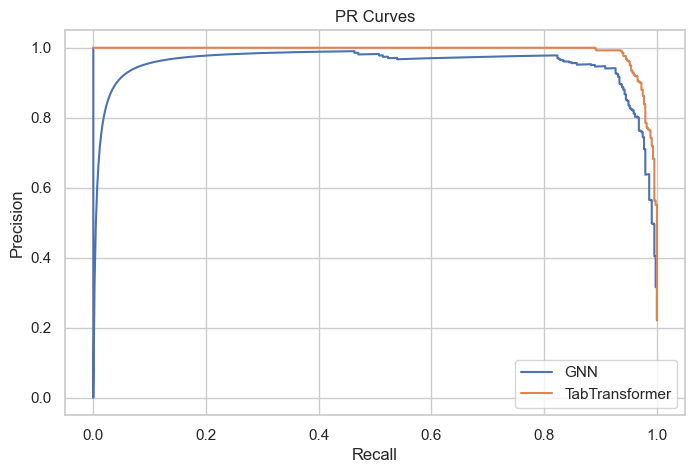

Done. Artifacts and models saved to ./artifacts


In [ ]:
# 8) Compare & plots (basic)
try:
    import matplotlib.pyplot as plt
    from sklearn.metrics import precision_recall_curve
    model.eval()
    with torch.no_grad():
        gnn_probs = torch.sigmoid(model(x_nodes, edge_index)).cpu().numpy()[test_idx]
    pr_g, rc_g, _ = precision_recall_curve(y[test_idx], gnn_probs)
    pr_t, rc_t, _ = precision_recall_curve(ytrue, logits)
    plt.figure(figsize=(8,5))
    plt.plot(rc_g, pr_g, label='GNN')
    plt.plot(rc_t, pr_t, label='TabTransformer')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.title('PR Curves')
    plt.show()
except Exception as e:
    print('Plotting failed:', e)

print('Done. Artifacts and models saved to', ARTIFACTS_DIR)


Using ARTIFACTS_DIR = ./artifacts
LightGBM load/predict failed: The number of features in data (47) is not the same as it was in training data (49).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.
Loaded GNN predictions.
Loaded TabTransformer predictions.

=== Model metrics ===
                 roc_auc    pr_auc  precision    recall        f1       acc
GNN             0.987636  0.945995   0.867089  0.942661  0.903297  0.955307
TabTransformer  0.996420  0.990552   0.973995  0.944954  0.959255  0.982224


C:\Users\manis\AppData\Local\Temp\ipykernel_11008\1722241579.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  art = torch.load(graph_art_path, map_location='cpu')
C:\Use

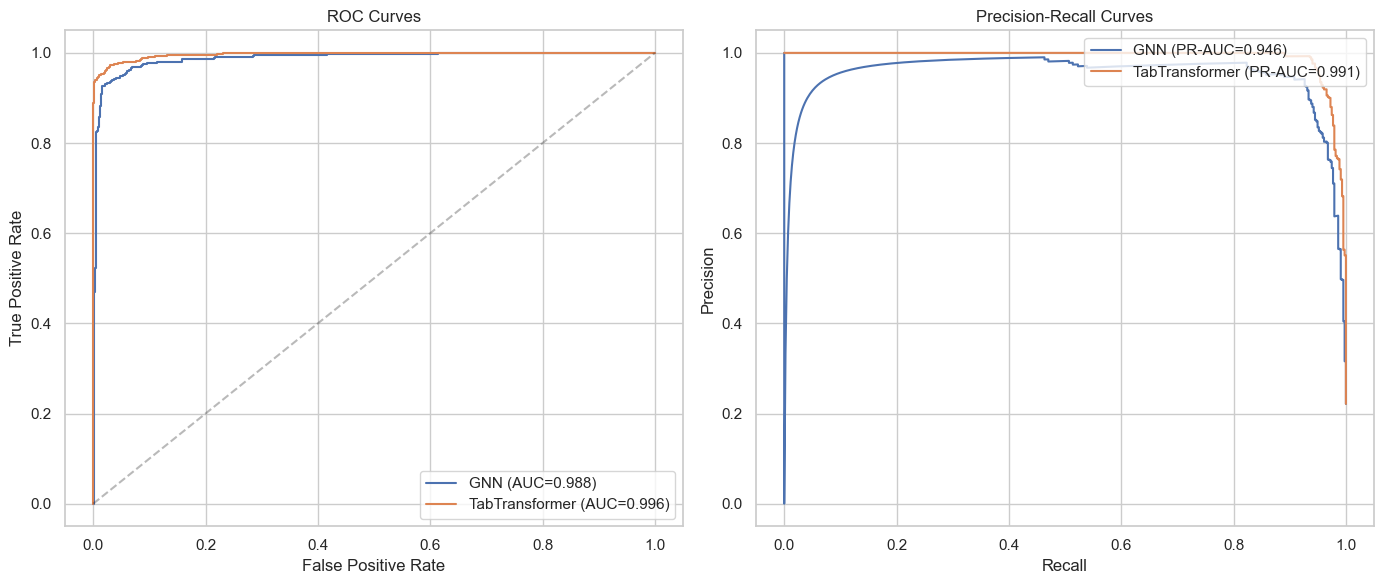

<Figure size 900x500 with 0 Axes>

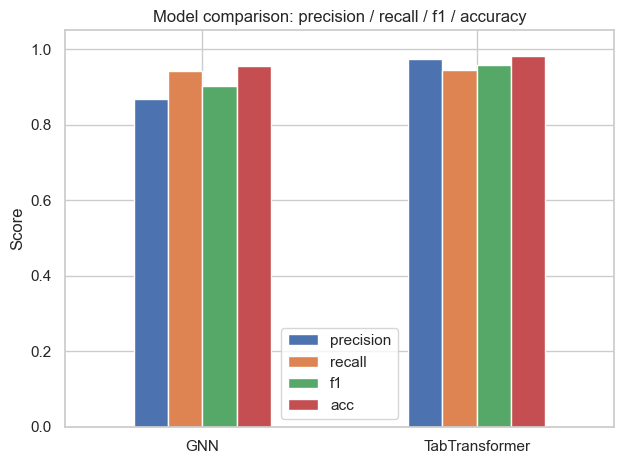

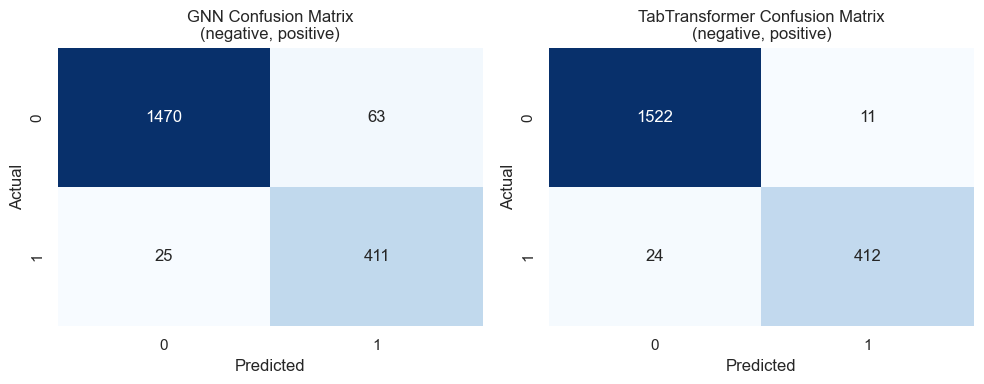

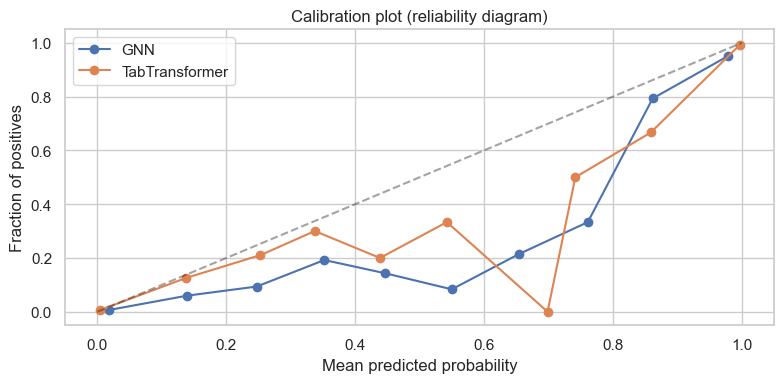


Saved plots + metrics CSV to: ./artifacts


In [ ]:
# === FINAL VISUALIZATION & METRICS SUMMARY CELL ===
import os, pickle, numpy as np, matplotlib.pyplot as plt, seaborn as sns, pandas as pd
from sklearn.metrics import (roc_curve, precision_recall_curve, roc_auc_score, auc,
                             precision_recall_fscore_support, accuracy_score, confusion_matrix)
from sklearn.model_selection import train_test_split
import torch

# choose artifacts dir (prefer local ./artifacts if exists)
if os.path.exists('./artifacts'):
    ARTIFACTS_DIR = './artifacts'
else:
    ARTIFACTS_DIR = '/mnt/data/artifacts'
os.makedirs(ARTIFACTS_DIR, exist_ok=True)
print("Using ARTIFACTS_DIR =", ARTIFACTS_DIR)

sns.set(style="whitegrid", font_scale=1.0)

# ---- load basic arrays ----
X_path = os.path.join(ARTIFACTS_DIR, 'X.npy')
y_path = os.path.join(ARTIFACTS_DIR, 'y.npy')
addrs_path = os.path.join(ARTIFACTS_DIR, 'addresses.npy')
preproc_path = os.path.join(ARTIFACTS_DIR, 'tab_preproc.pkl')
lgb_model_path = os.path.join(ARTIFACTS_DIR, 'lgb_baseline.txt')
gnn_model_path = os.path.join(ARTIFACTS_DIR, 'gnn_node_model.pt')
graph_art_path = os.path.join(ARTIFACTS_DIR, 'graph_artifacts.pt')
tab_model_path = os.path.join(ARTIFACTS_DIR, 'tabtransformer_model.pt')

assert os.path.exists(X_path) and os.path.exists(y_path), "X.npy or y.npy not found in ARTIFACTS_DIR."

X = np.load(X_path)
y = np.load(y_path)
addresses = np.load(addrs_path) if os.path.exists(addrs_path) else None

# reproduce the same splits used during training
SEED = 42
train_idx, test_idx = train_test_split(np.arange(len(y)), test_size=0.2, random_state=SEED, stratify=y)
train_idx, val_idx = train_test_split(train_idx, test_size=0.15, random_state=SEED, stratify=y[train_idx])

# container for model outputs
models = {}

# --- LightGBM predictions (if available) ---
if os.path.exists(lgb_model_path):
    try:
        import lightgbm as lgb
        bst = lgb.Booster(model_file=lgb_model_path)
        probs = bst.predict(X[test_idx])
        preds = (probs > 0.5).astype(int)
        models['LightGBM'] = {'probs': probs, 'preds': preds, 'true': y[test_idx]}
        print("Loaded LightGBM predictions.")
    except Exception as e:
        print("LightGBM load/predict failed:", e)
else:
    print("LightGBM model not found at", lgb_model_path)

# --- GNN predictions (if available) ---
if os.path.exists(graph_art_path) and os.path.exists(gnn_model_path):
    try:
        art = torch.load(graph_art_path, map_location='cpu')
        edge_index = art['edge_index']
        x_nodes = art['x']
        # build model class (must match training)
        import torch.nn as nn
        import torch.nn.functional as F
        from torch_geometric.nn import SAGEConv

        class NodeGNN(nn.Module):
            def __init__(self, in_ch, hidden=128, num_layers=2):
                super().__init__()
                self.convs = nn.ModuleList()
                self.convs.append(SAGEConv(in_ch, hidden))
                for _ in range(num_layers-1):
                    self.convs.append(SAGEConv(hidden, hidden))
                self.head = nn.Linear(hidden, 1)
            def forward(self, x, edge_index):
                for conv in self.convs:
                    x = conv(x, edge_index)
                    x = F.relu(x)
                return self.head(x).squeeze(-1)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = NodeGNN(in_ch=x_nodes.shape[1], hidden=128, num_layers=2).to(device)
        model.load_state_dict(torch.load(gnn_model_path, map_location=device))
        model.eval()
        with torch.no_grad():
            logits = model(x_nodes.to(device), edge_index.to(device)).cpu().numpy()
            probs = 1.0 / (1.0 + np.exp(-logits))
            preds = (probs > 0.5).astype(int)
        models['GNN'] = {'probs': probs[test_idx], 'preds': preds[test_idx], 'true': y[test_idx]}
        print("Loaded GNN predictions.")
    except Exception as e:
        print("GNN load/predict failed:", e)
else:
    print("GNN artifacts or model missing (skipping).")

# --- TabTransformer predictions (if available) ---
if os.path.exists(tab_model_path) and os.path.exists(preproc_path):
    try:
        with open(preproc_path, 'rb') as f:
            preproc = pickle.load(f)  # we may not need it here but good to load
        num_cont = X.shape[1]
        import torch.nn as nn
        class TabTransformer(nn.Module):
            def __init__(self, num_tokens, num_cont, d_model=64, n_heads=4, n_layers=2, dropout=0.1):
                super().__init__()
                self.input_proj = nn.Linear(num_cont, d_model)
                encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=d_model*4, dropout=dropout, batch_first=True)
                self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
                self.head = nn.Sequential(nn.Linear(d_model, 128), nn.ReLU(), nn.Dropout(dropout), nn.Linear(128,1))
            def forward(self, x_cont):
                token = self.input_proj(x_cont).unsqueeze(1)
                token = self.transformer(token)
                token = token.squeeze(1)
                logits = self.head(token).squeeze(-1)
                return logits

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model_tab = TabTransformer(num_tokens=1, num_cont=num_cont, d_model=64, n_heads=4, n_layers=2).to(device)
        model_tab.load_state_dict(torch.load(tab_model_path, map_location=device))
        model_tab.eval()
        with torch.no_grad():
            X_t = torch.tensor(X[test_idx], dtype=torch.float).to(device)
            logits = model_tab(X_t).cpu().numpy()
            probs = 1.0 / (1.0 + np.exp(-logits))
            preds = (probs > 0.5).astype(int)
        models['TabTransformer'] = {'probs': probs, 'preds': preds, 'true': y[test_idx]}
        print("Loaded TabTransformer predictions.")
    except Exception as e:
        print("TabTransformer load/predict failed:", e)
else:
    print("TabTransformer model or preproc not found (skipping).")

# ---- compute metrics for available models ----
if not models:
    raise RuntimeError("No model outputs found in ARTIFACTS_DIR. Please ensure you have models saved.")

metrics = {}
for name, dat in models.items():
    probs = dat['probs']
    preds = dat['preds']
    true = dat['true']
    roc_auc = roc_auc_score(true, probs) if len(np.unique(true)) > 1 else float('nan')
    pr, rc, _ = precision_recall_curve(true, probs)
    pr_auc = auc(rc, pr)
    prec, rec, f1, _ = precision_recall_fscore_support(true, preds, average='binary', zero_division=0)
    acc = accuracy_score(true, preds)
    metrics[name] = {'roc_auc': roc_auc, 'pr_auc': pr_auc, 'precision': prec, 'recall': rec, 'f1': f1, 'acc': acc}

metrics_df = pd.DataFrame(metrics).T
metrics_df = metrics_df[['roc_auc','pr_auc','precision','recall','f1','acc']]
print("\n=== Model metrics ===")
print(metrics_df.round(6))
metrics_df.to_csv(os.path.join(ARTIFACTS_DIR, 'model_metrics_summary.csv'))

# ---- Plot ROC and PR curves ----
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
for name, dat in models.items():
    fpr, tpr, _ = roc_curve(dat['true'], dat['probs'])
    plt.plot(fpr, tpr, label=f"{name} (AUC={metrics[name]['roc_auc']:.3f})")
plt.plot([0,1],[0,1],'k--', alpha=0.3)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves')
plt.legend(loc='lower right'); plt.grid(True)

plt.subplot(1,2,2)
for name, dat in models.items():
    pr, rc, _ = precision_recall_curve(dat['true'], dat['probs'])
    plt.plot(rc, pr, label=f"{name} (PR-AUC={metrics[name]['pr_auc']:.3f})")
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curves')
plt.legend(loc='upper right'); plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, 'roc_pr_comparison.png'), bbox_inches='tight', dpi=150)
plt.show()

# ---- Bar chart: precision/recall/f1/acc ----
plt.figure(figsize=(9,5))
plot_df = metrics_df[['precision','recall','f1','acc']].copy()
plot_df.plot(kind='bar', rot=0)
plt.ylim(0,1.05)
plt.title('Model comparison: precision / recall / f1 / accuracy')
plt.ylabel('Score')
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, 'metrics_bar_comparison.png'), bbox_inches='tight', dpi=150)
plt.show()

# ---- Confusion matrices ----
n = len(models)
plt.figure(figsize=(5*n,4))
for i,(name, dat) in enumerate(models.items(),1):
    cm = confusion_matrix(dat['true'], dat['preds'])
    plt.subplot(1,n,i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{name} Confusion Matrix\n(negative, positive)")
    plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, 'confusion_matrices.png'), bbox_inches='tight', dpi=150)
plt.show()

# ---- Calibration plot (reliability diagram) ----
from sklearn.calibration import calibration_curve
plt.figure(figsize=(8,4))
for name, dat in models.items():
    frac_pos, mean_pred = calibration_curve(dat['true'], dat['probs'], n_bins=10)
    plt.plot(mean_pred, frac_pos, marker='o', label=name)
plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.title('Calibration plot (reliability diagram)')
plt.xlabel('Mean predicted probability'); plt.ylabel('Fraction of positives')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, 'calibration_plot.png'), bbox_inches='tight', dpi=150)
plt.show()

print(f"\nSaved plots + metrics CSV to: {ARTIFACTS_DIR}")


In [ ]:
import numpy as np, pandas as pd, os
ARTIFACTS_DIR = './artifacts'

# load original dataframe (path from your notebook)
df = pd.read_csv('E:/Projects/CBK_Assignment/Greenland_Registry/ethereum_raw.csv', low_memory=False)  # or use the same path you used
label = 'FLAG'

features = [c for c in df.columns if c not in ('Address', label, 'flag', 'Flag')]

# 1) exact-equality check
eq_feats = []
for c in features:
    try:
        if (df[c].fillna('<<NA>>').astype(str) == df[label].astype(str)).all():
            eq_feats.append(c)
    except Exception:
        pass

print("Features exactly equal to LABEL (if any):", eq_feats)

# 2) near-perfect univariate AUC
from sklearn.metrics import roc_auc_score
uni_auc = {}
y = df[label].values
for c in features:
    try:
        # numeric or encoded categorical
        col = df[c].fillna(-999).astype(float)
        # skip constant
        if np.unique(col).size <= 1:
            continue
        # if values are not numeric, try mapping categories to integers by freq
        if col.dtype == object or not np.issubdtype(col.dtype, np.number):
            mapping = {v:i for i,v in enumerate(col.astype(str).unique())}
            col = col.astype(str).map(mapping).astype(float).values
        else:
            col = col.values
        auc = roc_auc_score(y, col)
        uni_auc[c] = max(auc, 1-auc)  # consider absolute separation
    except Exception:
        continue

# show top features by univariate AUC
top = sorted(uni_auc.items(), key=lambda x: -x[1])[:20]
print("\nTop features by univariate AUC (name, AUC):")
for k,v in top:
    print(k, v)


Features exactly equal to LABEL (if any): []

Top features by univariate AUC (name, AUC):
Unnamed: 0 1.0
total ether received 0.8166176893914754
avg val received 0.7929807185146559
max value received  0.7820369898519948
total Ether sent 0.7320527366119897
Sent tnx 0.7221236527356056
Index 0.7156095014356565
 ERC20 uniq sent addr 0.7124138794781683
 ERC20 uniq sent token name 0.7109545339707746
 ERC20 total ether sent 0.7108740032792074
 ERC20 max val sent 0.7104116930204777
 ERC20 avg val sent 0.7099665430764628
min value received 0.703607014298106
max val sent 0.7006874248375221
 ERC20 min val sent 0.6985024046602264
 ERC20 uniq sent addr.1 0.6902775826153853
 ERC20 total Ether sent contract 0.6902768039623616
 ERC20 avg time between sent tnx 0.6902248737953189
 ERC20 avg time between rec tnx 0.6902248737953189
 ERC20 avg time between rec 2 tnx 0.6902248737953189


In [ ]:
# load tuned model you just saved
import joblib
best = joblib.load(os.path.join(ARTIFACTS_DIR, "lgb_best.pkl"))
feat_names = np.load(os.path.join(ARTIFACTS_DIR, "feature_names.npy")) if os.path.exists(os.path.join(ARTIFACTS_DIR, "feature_names.npy")) else None

importances = best.feature_importances_
order = np.argsort(importances)[::-1][:30]
print("Top 30 feature importances (index, score):")
for i in order:
    name = feat_names[i] if feat_names is not None else f"f{i}"
    print(name, importances[i])


Top 30 feature importances (index, score):
f2 1928
f5 1114
f16 1009
f1 973
f15 867
f46 845
f9 826
f0 813
f10 716
f8 715
f13 667
f14 649
f7 620
f4 573
f12 491
f45 487
f3 454
f17 414
f11 408
f18 398
f23 338
f6 320
f24 268
f25 255
f20 249
f19 242
f22 232
f21 214
f26 194
f28 178


In [ ]:
import os, pickle, numpy as np, pandas as pd
ARTIFACTS_DIR = './artifacts'

# load preproc meta
with open(os.path.join(ARTIFACTS_DIR, "preproc_train_encoders.pkl"), "rb") as f:
    meta = pickle.load(f)

numeric_cols = meta['numeric_cols']
categorical_cols = meta['categorical_cols']
feature_cols = meta.get('feature_cols', numeric_cols + categorical_cols)

print("Total features (feature_cols length):", len(feature_cols))
print("Numeric cols (count):", len(numeric_cols))
print("Categorical cols (count):", len(categorical_cols))
print("\nFirst 30 features (in order expected):")
print(feature_cols[:30])

# load X_train to inspect shape and some rows
X_train = np.load(os.path.join(ARTIFACTS_DIR, "X_train.npy"))
print("\nX_train shape:", X_train.shape)
# Make a small DataFrame to display first 5 rows with column names
df_Xtrain = pd.DataFrame(X_train[:5, :], columns=feature_cols)
display(df_Xtrain)


Total features (feature_cols length): 47
Numeric cols (count): 31
Categorical cols (count): 16

First 30 features (in order expected):
['Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Number of Created Contracts', 'Unique Received From Addresses', 'Unique Sent To Addresses', 'min value received', 'max value received ', 'avg val received', 'min val sent', 'max val sent', 'avg val sent', 'min value sent to contract', 'max val sent to contract', 'avg value sent to contract', 'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received', 'total ether sent contracts', 'total ether balance', ' Total ERC20 tnxs', ' ERC20 total Ether received', ' ERC20 total ether sent', ' ERC20 total Ether sent contract', ' ERC20 uniq sent addr', ' ERC20 uniq rec addr', ' ERC20 uniq sent addr.1', ' ERC20 uniq rec contract addr']

X_train shape: (6691, 47)


,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,-0.244102,-0.284347,0.016588,-0.152571,-0.023832,-0.098593,-0.101792,-0.133156,-0.043788,-0.032947,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,90.0
1,-0.182187,-0.222369,0.631482,-0.068774,-0.055729,-0.098593,-0.094003,-0.133010,-0.043964,-0.033322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,170.0
2,-0.244102,0.737654,-0.068964,-0.152571,-0.165824,-0.088642,-0.101792,-0.133156,-0.040741,-0.030628,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,235.0
3,-0.244102,-0.352443,-0.679549,-0.151262,-0.173027,-0.101910,-0.097898,-0.118499,-0.043661,-0.031947,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0
4,-0.243101,-0.352443,-0.679775,-0.149952,-0.173027,-0.101910,-0.094003,0.162915,-0.037571,-0.004430,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0


In [ ]:
leaks = [c for c in ['Unnamed: 0', 'Index'] if c in feature_cols]
print("Leaky columns present in feature_cols:", leaks)

# also check original df if available
if os.path.exists('/mnt/data/ethereum_raw.csv'):
    df = pd.read_csv('/mnt/data/ethereum_raw.csv', low_memory=False)
    print("Original df columns containing 'Unnamed' or 'Index':", [c for c in df.columns if 'Unnamed' in c or 'Index' in c])


Leaky columns present in feature_cols: []


In [ ]:
# Confirm dropped leak and consistent columns
print('Unnamed: 0' in meta['feature_cols'])  # should print False
print("Shapes:", X_train.shape, X_val.shape, X_test.shape)


False
Shapes: (6691, 47) (1181, 47) (1969, 47)


In [ ]:
# Check address overlap (just in case)
import numpy as np, os
a_tr = np.load(os.path.join(ARTIFACTS_DIR, "addresses_train.npy"), allow_pickle=True)
a_te = np.load(os.path.join(ARTIFACTS_DIR, "addresses_test.npy"), allow_pickle=True)
print("Train/Test address overlap:", len(set(a_tr).intersection(set(a_te))))


Train/Test address overlap: 9


In [ ]:
import os
for f in os.listdir('./artifacts'):
    os.remove(os.path.join('./artifacts', f))
print("Cleared artifacts folder.")


Cleared artifacts folder.
